In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as scipyFit
import seaborn as sns
from sklearn.metrics import r2_score

# Radiosonde data acquisition
This script downloads radiosonde data from the University of Wyoming archive for the station of S.Pietro Capofiume (station code = 16144).

These data are collected using wheather ballons and contain information about temperature and pressure at different altitudes. The code requires some parameters:

*   Station code, e.g. 16144 represents S.Pietro Capofiume. On the University of Wyoming website there is the map of all stations that provide data with its code;
*   Target altitudes in meters, that can be defined in the variable heights_m;
*   Time period of the analysis, that can be changed using the variables start_date and end_date;
*   Hours of radiosonde launch times in UTC, they usually take place at 00:00 and 12:00, but it may vary depending on the station.

After downloading the Radiosonde report, this code interpolates data to obtain temperature and pressure measurements at the specified heights.

Then, it saves data in a pandas dataframe and exports them to a CSV file, which can be used to examine the data of each launch.






In [ ]:

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Choose the parameters
station = "16144"  # Station number (in the example is San Pietro Capofiume (BO))
heights_m = [50,1000, 3000, 5000, 10000, 15000]  # Target altitudes in meters
start_date = datetime(2024, 1, 1)  #  Start date of analysis (YYYY, M, D)
end_date = datetime(2024, 1, 10)     # End date of analysis (YYYY, M, D)
hours = ["00", "12"]                # Radiosonde launch times in UTC (usually 00:00 and 12:00)

# Create a list to store data
data = []

# Function to download a sounding from a given data, time and station
def fetch_sounding(date, hour, station):
    base_url = "http://weather.uwyo.edu/cgi-bin/sounding"
    params = {
        "region": "europe",
        "TYPE": "TEXT:LIST",
        "YEAR": date.year,
        "MONTH": f"{date.month:02}",
        "FROM": f"{date.day:02}{hour}",
        "TO": f"{date.day:02}{hour}",
        "STNM": station
    }
    response = requests.get(base_url, params=params)
    if "Can't" in response.text or "PRES" not in response.text:
        return None
    return response.text

# Loop over date and time
date = start_date
while date <= end_date:
    for hour in hours:
        text = fetch_sounding(date, hour, station)
        if text:
            lines = text.split("\n")
            # Locate the start of the table (header line containing "pres")
            try:
                start_idx = next(i for i, line in enumerate(lines) if "PRES" in line)
            except StopIteration:
                continue  # if the table is not found, skip the sounding
            table = lines[start_idx + 2:]
            profile = []
            for row in table:
                cols = row.split()
                if len(cols) < 3: # Add check for sufficient columns
                    continue
                try:
                    pres = float(cols[0])      # Pressure in hPa
                    height = float(cols[1])    # Height in m
                    temp = float(cols[2])       # Temperature in °C
                    profile.append((height, pres,temp))
                except ValueError:
                    continue
            # Interpolate at target heights
            for target_h in heights_m:
                heights, pressures,temperatures = zip(*profile)
                # Only if the target height is within the profile
                if min(heights) <= target_h <= max(heights):
                    p_interp = np.interp(target_h, heights, pressures)
                    t_interp = np.interp(target_h, heights, temperatures)
                    # Keep only realistic pressures
                    if 100 < p_interp < 1050:
                        timestamp = datetime(date.year, date.month, date.day, int(hour))
                        data.append([timestamp, target_h, p_interp, t_interp])
    # Go to the next day
    date += timedelta(days=1)

#  Create a DataFrame
df = pd.DataFrame(data, columns=["DateTime", "Height_m", "Pressure_hPa", "Temperature_C"])

# Pivot: rows=datetime, columns=heights, data=pressure/temperature
pivot_df_pressure = df.pivot(index="DateTime", columns="Height_m", values="Pressure_hPa")
pivot_df_temperature = df.pivot(index="DateTime", columns="Height_m", values="Temperature_C")

# Keep only available data
pivot_df_pressure = pivot_df_pressure.dropna()
pivot_df_temperature = pivot_df_temperature.dropna()


# Save data in CSV
pivot_df_pressure.to_csv("radiosonde_pressure.csv")
print(" Dati con timestamp comuni salvati in radiosonde_pressure.csv")

pivot_df_temperature.to_csv("radiosonde_temperature.csv")
print(" Dati con timestamp comuni salvati in radiosonde_temperature.csv")



 Dati con timestamp comuni salvati in radiosonde_pressure.csv
 Dati con timestamp comuni salvati in radiosonde_temperature.csv


# Temperature and pressure over time
This code uses the previously collected data to generate two types of plot:
*   the comparison of pressure/temperature over time at defined heights;
*   The trend of pressure/temperature over time at each altitude separately.

By analysing this plots, you can identify similarities and differences in the evolution of pressure/temperature over time at different altitudes to evaluate possible connections between them. You can also study the trend of an atmospheric parameter at a single height to understand how it changed during the period of observation.



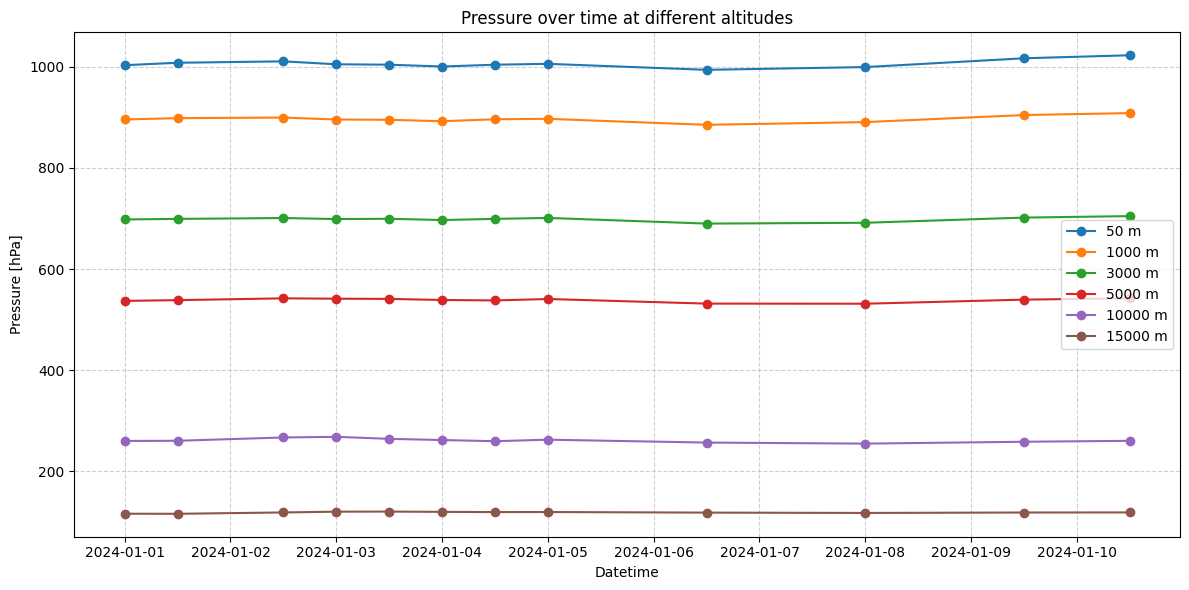

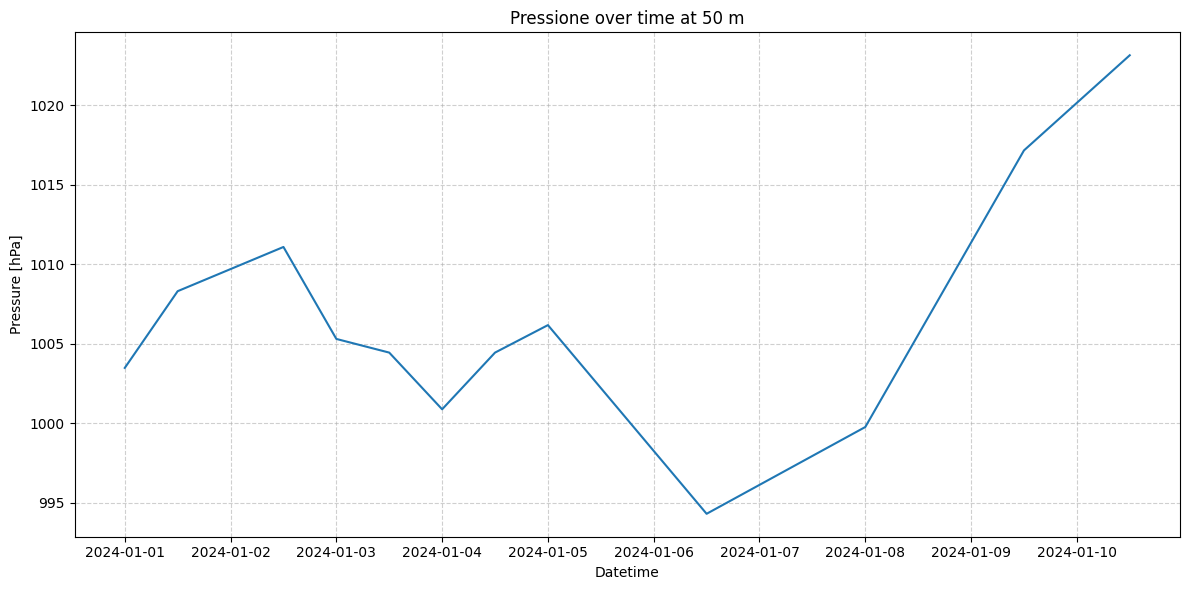

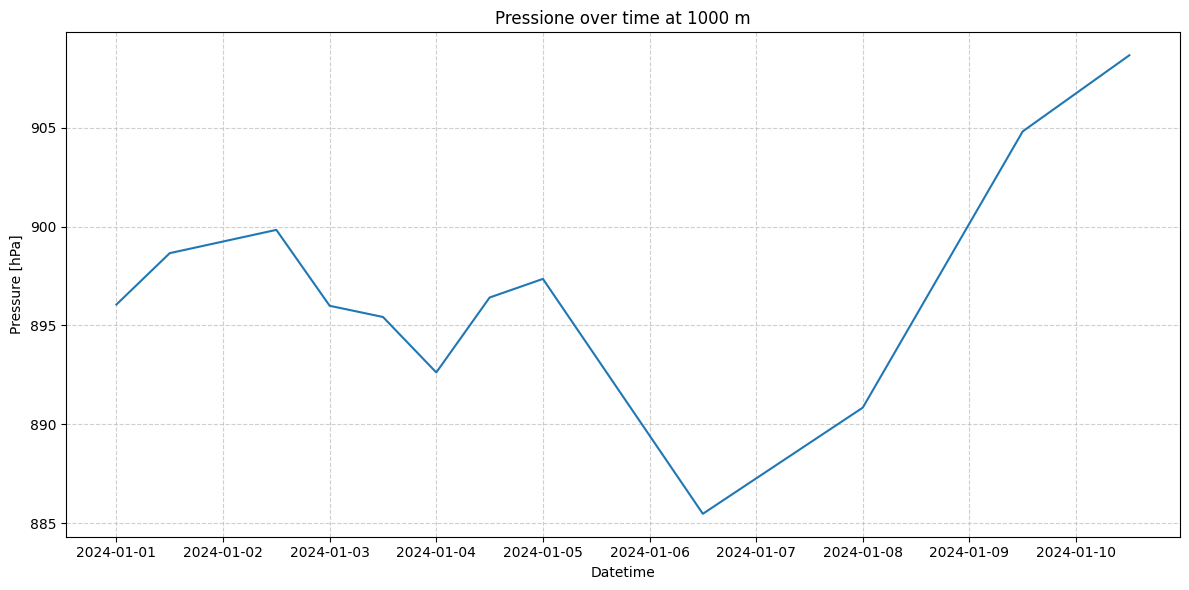

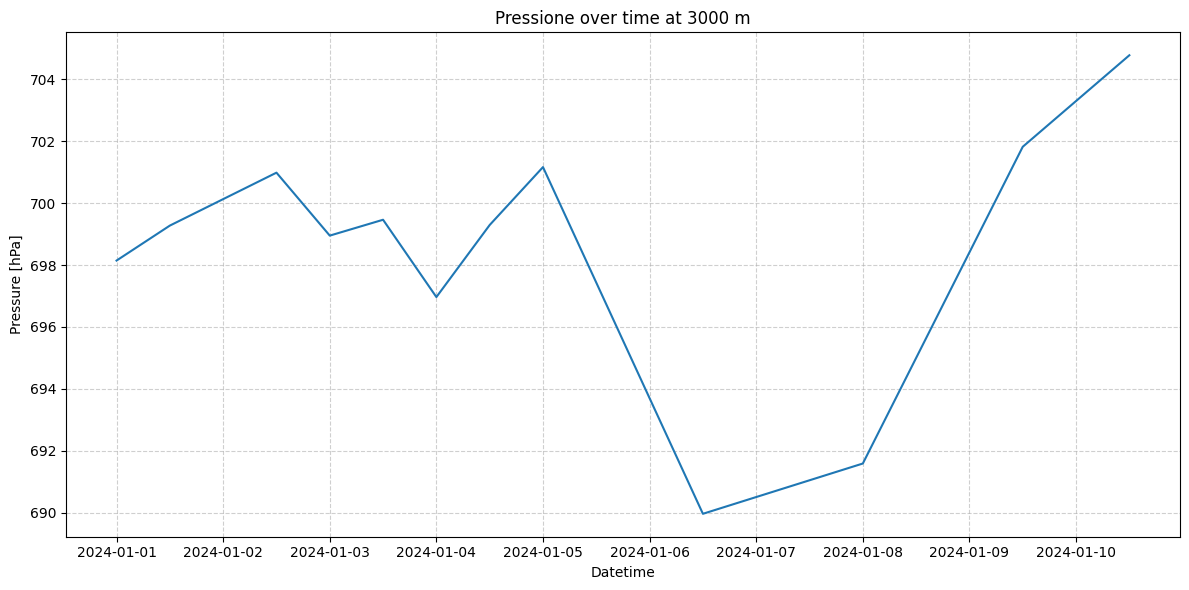

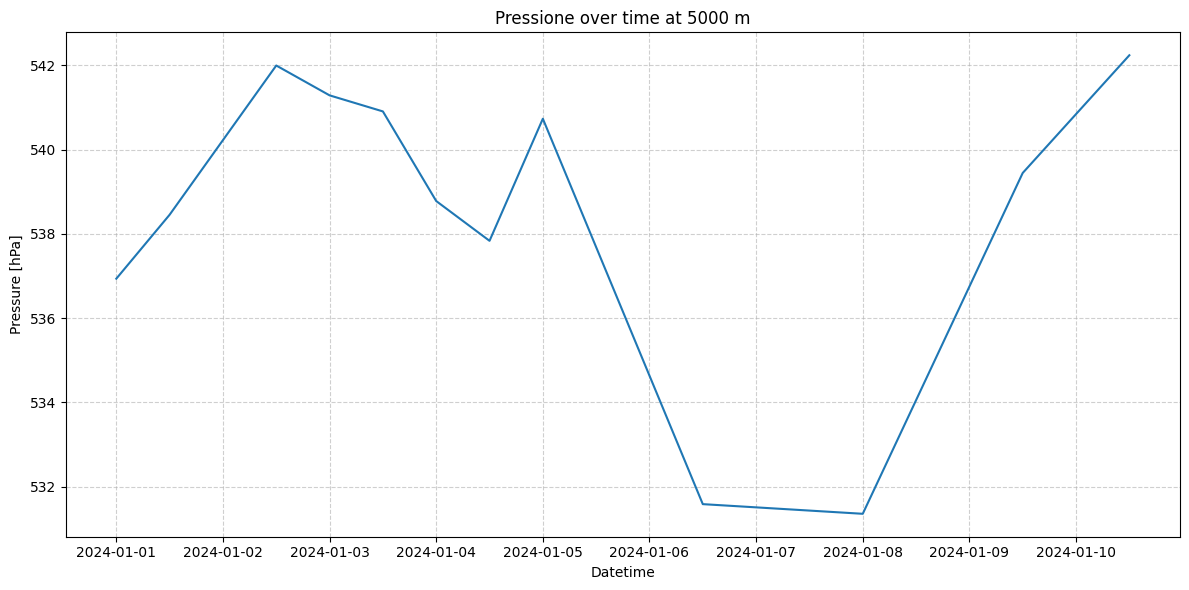

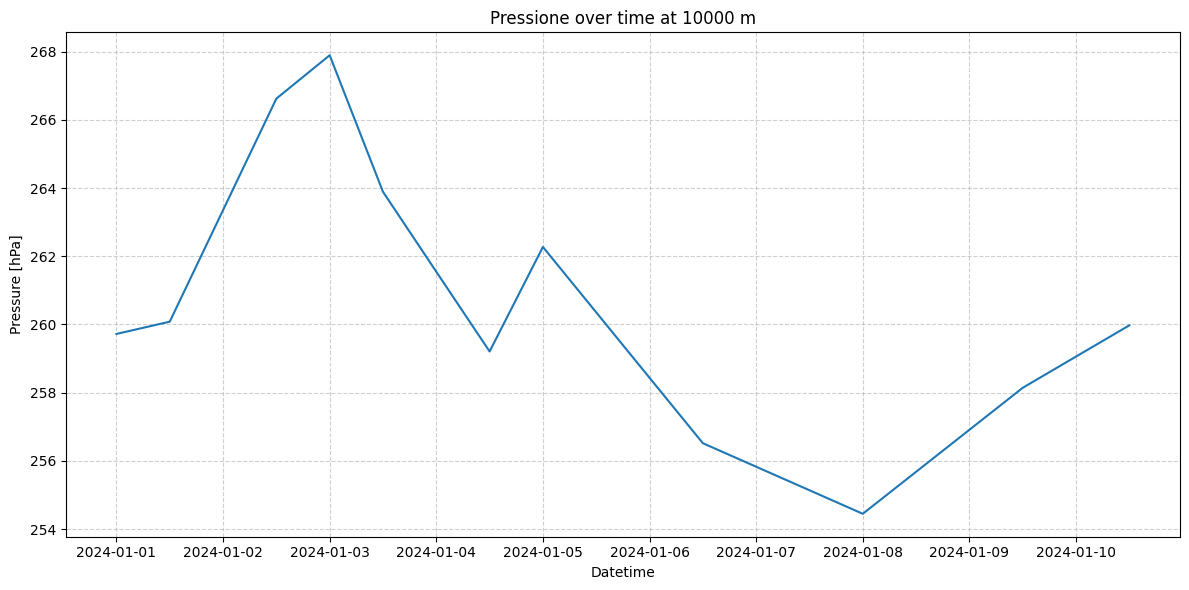

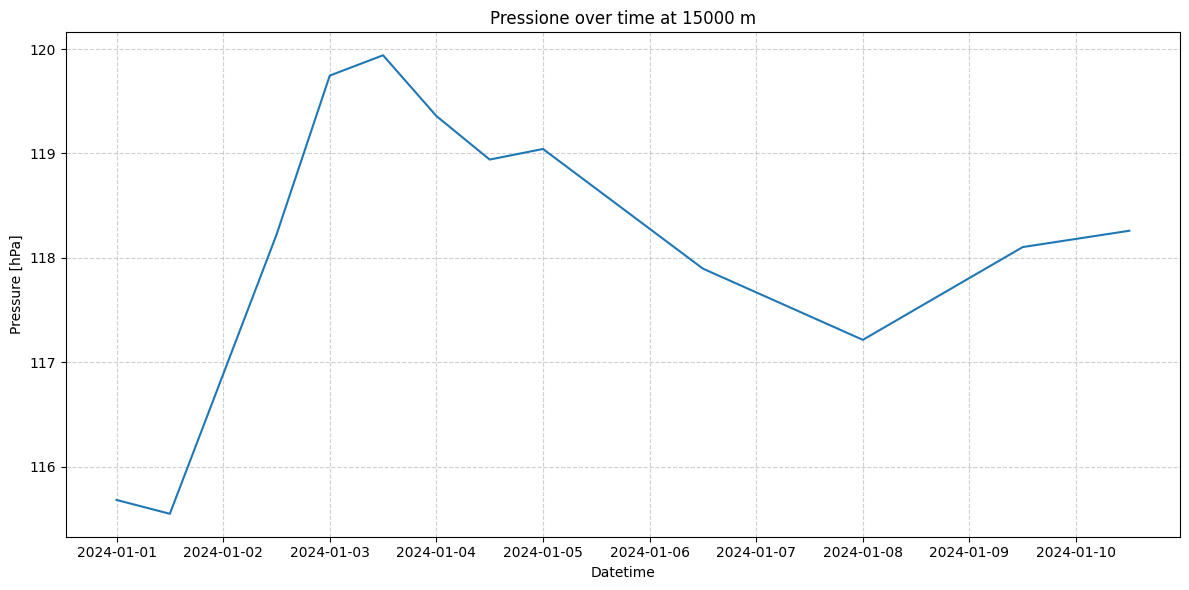

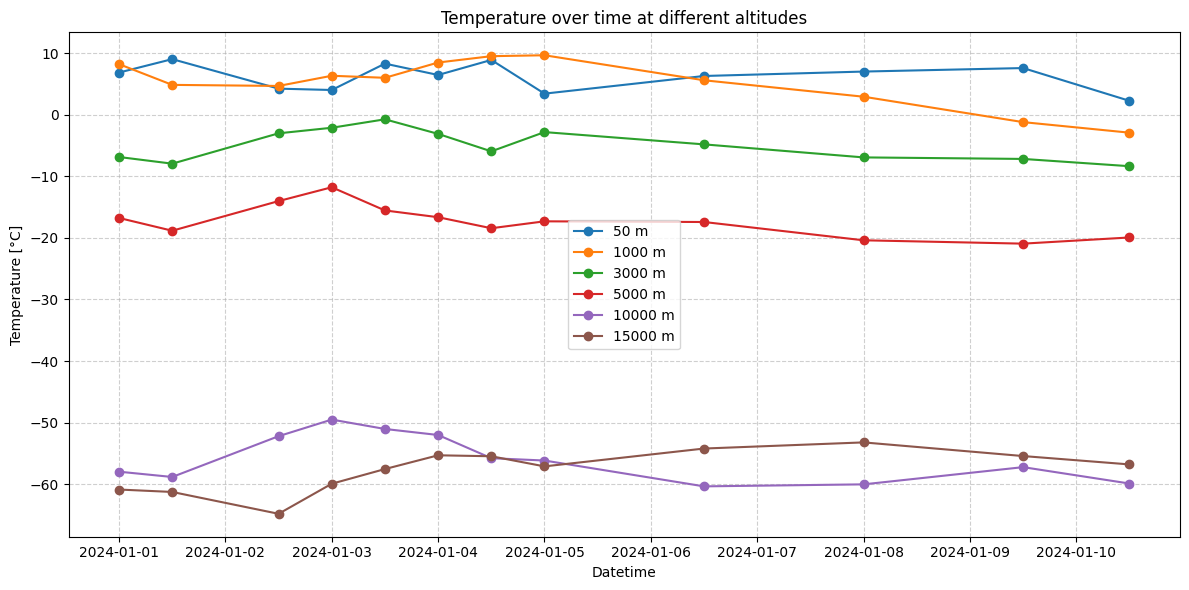

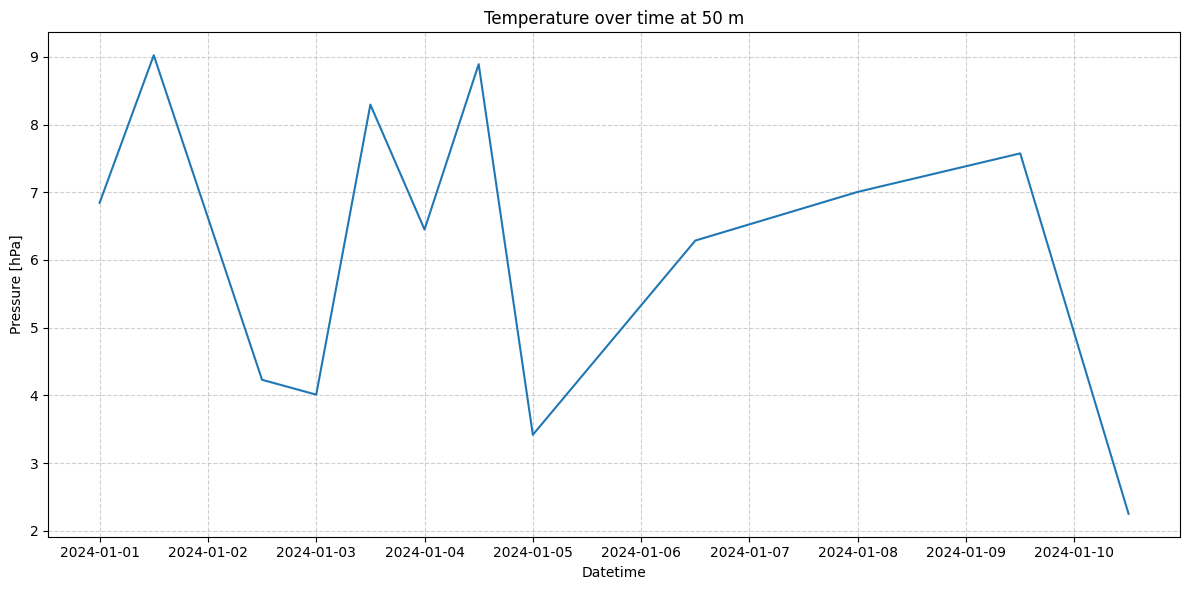

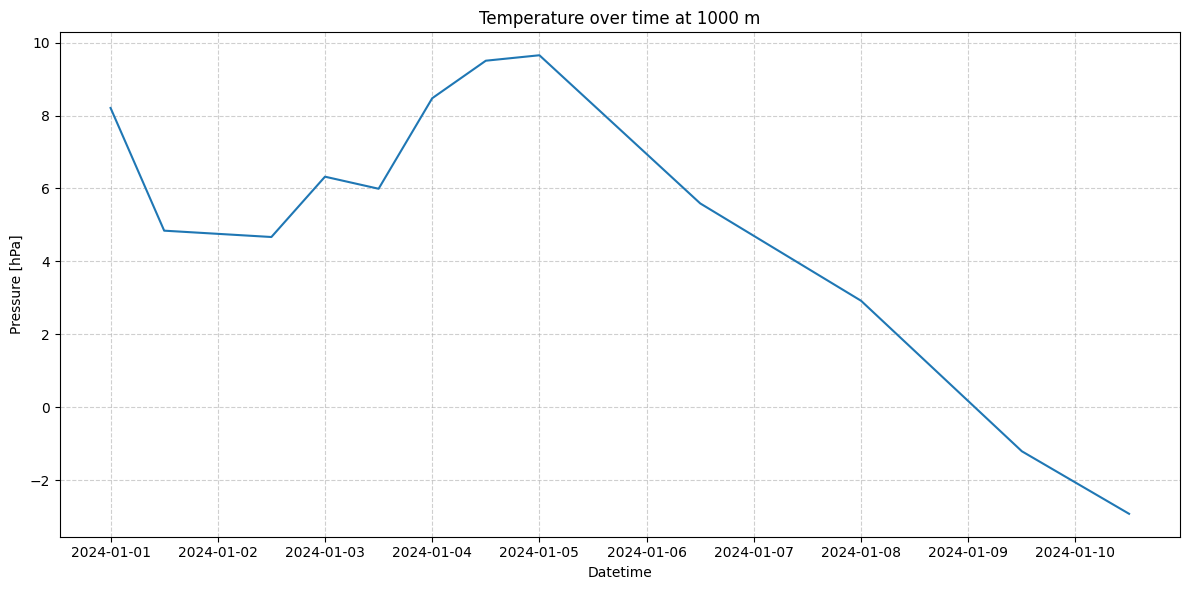

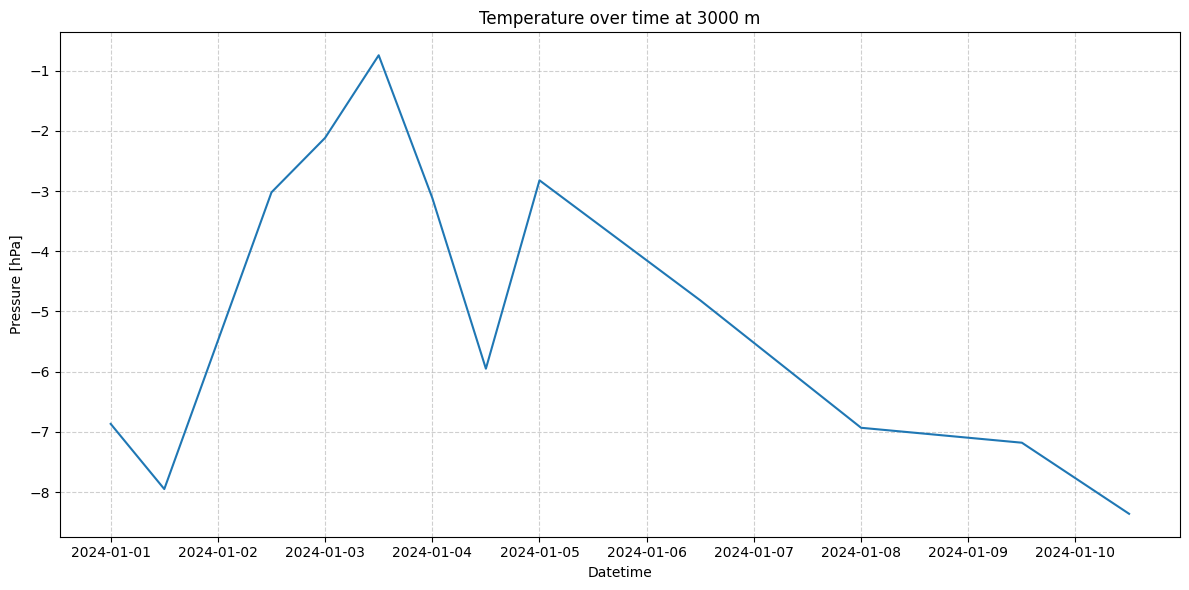

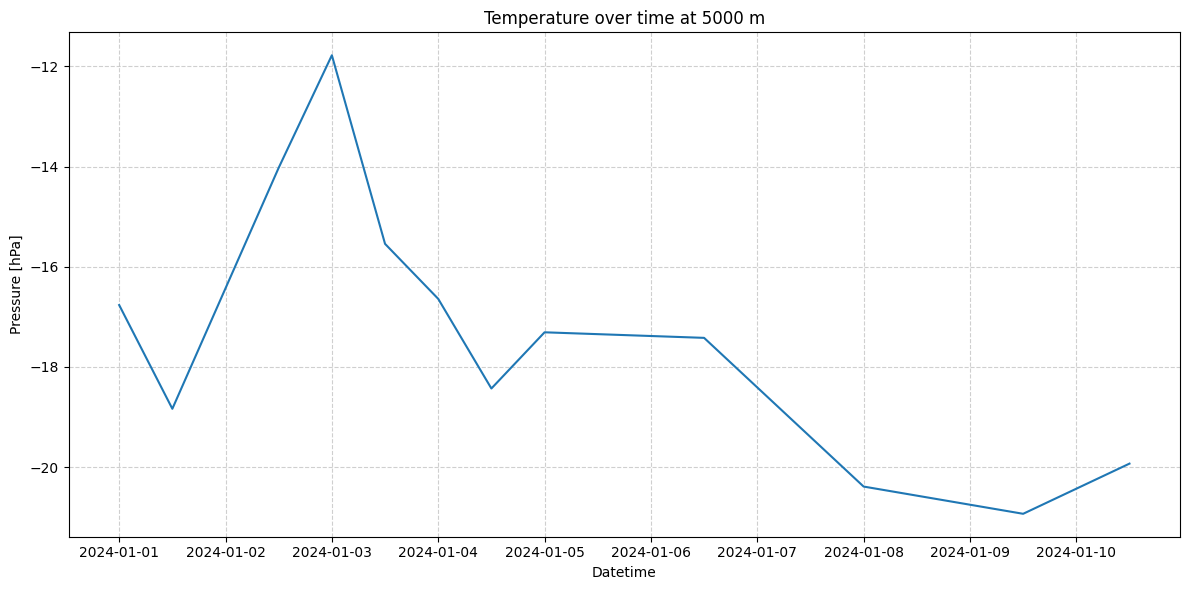

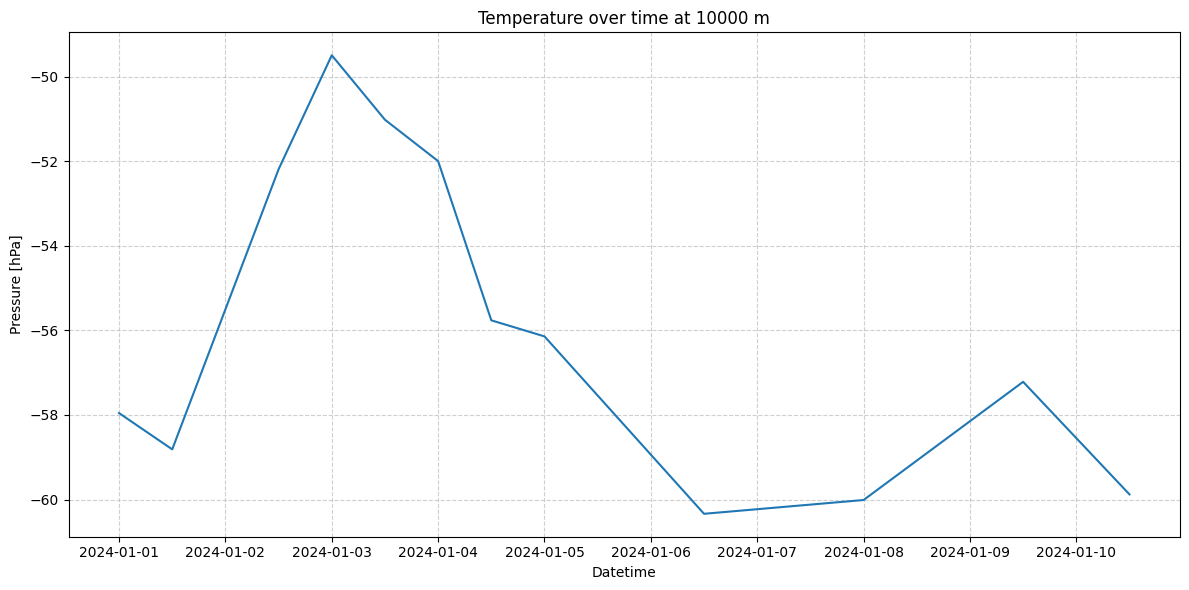

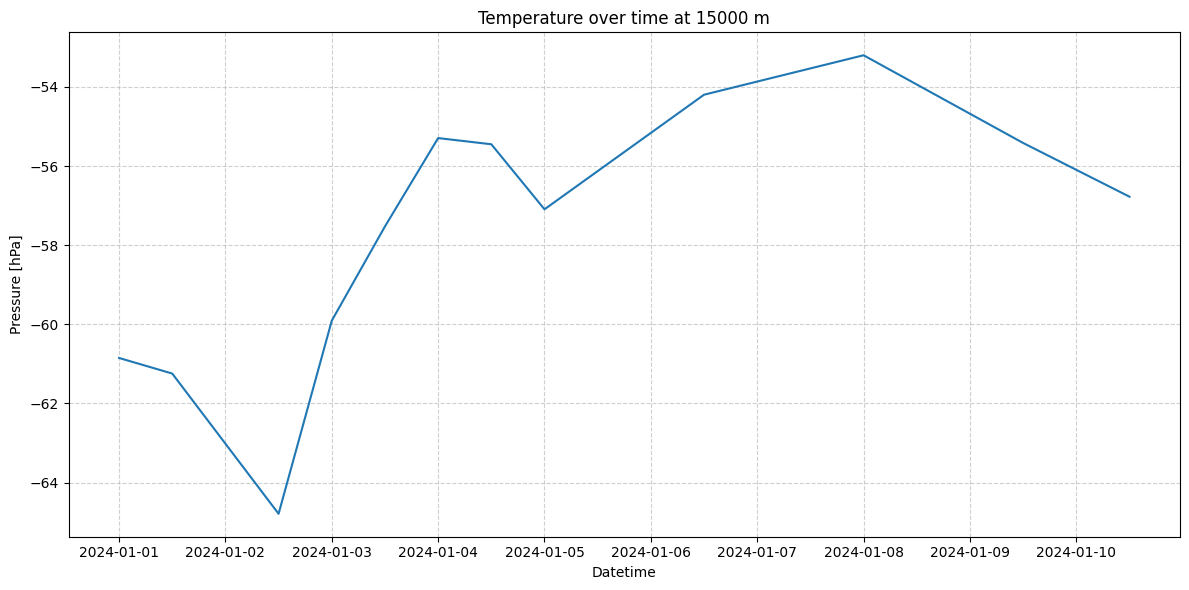

In [ ]:
# Plot a comparison of pressures over time at different target heights
plt.figure(figsize=(12, 6))
for height in heights_m:
    plt.plot(pivot_df_pressure.index, pivot_df_pressure[height], marker='o', linestyle='-', label=f"{height} m")
plt.title("Pressure over time at different altitudes")
plt.xlabel("Datetime")
plt.ylabel("Pressure [hPa]")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Plot pressure trend over time at each heights separately
for height in heights_m:
    plt.figure(figsize=(12, 6))
    plt.plot(pivot_df_pressure.index, pivot_df_pressure[height], linestyle='-')
    plt.title(f"Pressure over time at {height} m")
    plt.xlabel("Datetime")
    plt.ylabel("Pressure [hPa]")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot a comparison of temperatures over time at different target heights
plt.figure(figsize=(12, 6))
for height in heights_m:
    plt.plot(pivot_df_temperature.index, pivot_df_temperature[height], marker='o', linestyle='-', label=f"{height} m")
plt.title("Temperature over time at different altitudes")
plt.xlabel("Datetime")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# Plot temperature trend over time at each heights separately
for height in heights_m:
    plt.figure(figsize=(12, 6))
    plt.plot(pivot_df_temperature.index, pivot_df_temperature[height], linestyle='-')
    plt.title(f"Temperature over time at {height} m")
    plt.xlabel("Datetime")
    plt.ylabel("Pressure [hPa]")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


# Comparison plot
The next step is the comparison between ground-level pressure/temperature and the same atmospheric parameter at different altitudes.

This code generates scatter plots that represent the pressure/temperature data of each radiosonde at two heights: ground level and another target height chosen from the parameter heights_m.

A regression line is used to identify a linear correlation between the two physical quantities. The R^2 values, also known as the coefficient of determination, represent the portion of variance explained by the linear model: a high value indicates that the model predicts well the parameters trend.

In addition, the plot shows a confidence interval of 95%: the more points that fall within this interval, the better the model can explain the variance of the phenomenon.

Index(['DateTime', 'Height_m', 'Pressure_hPa', 'Temperature_C'], dtype='object')


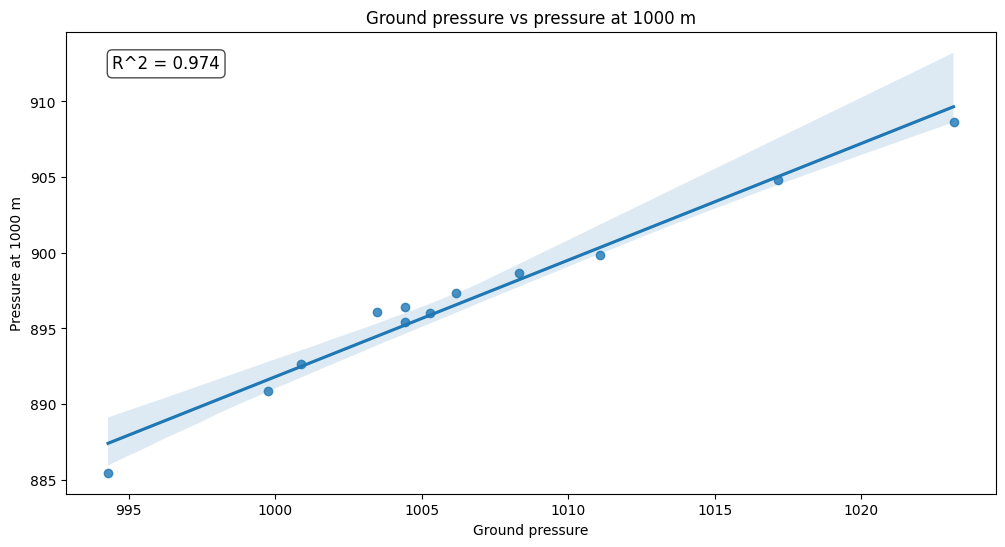

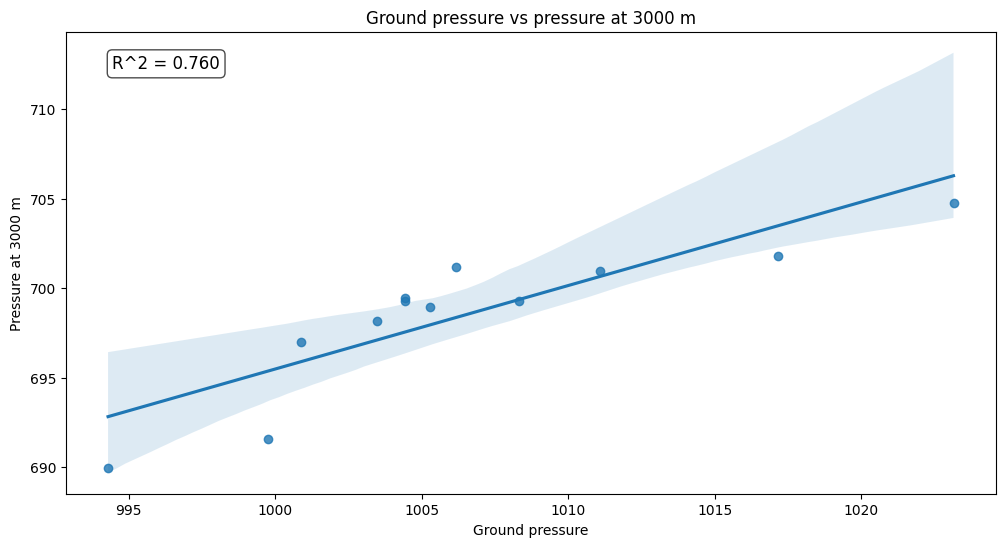

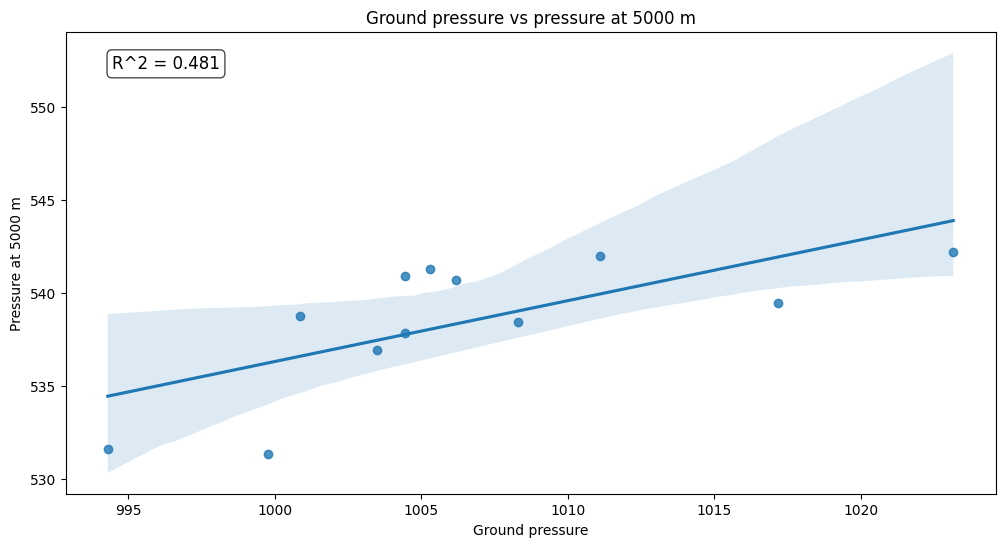

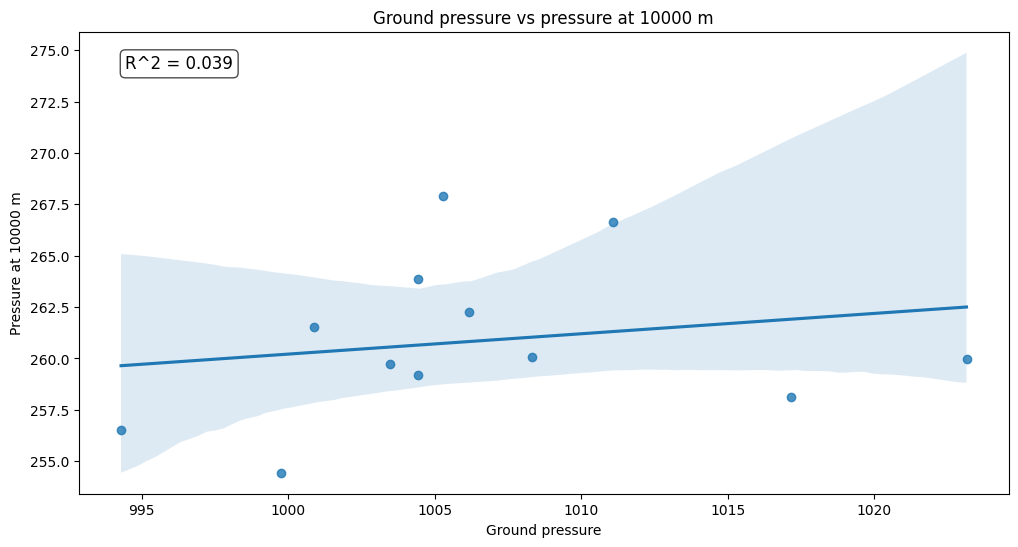

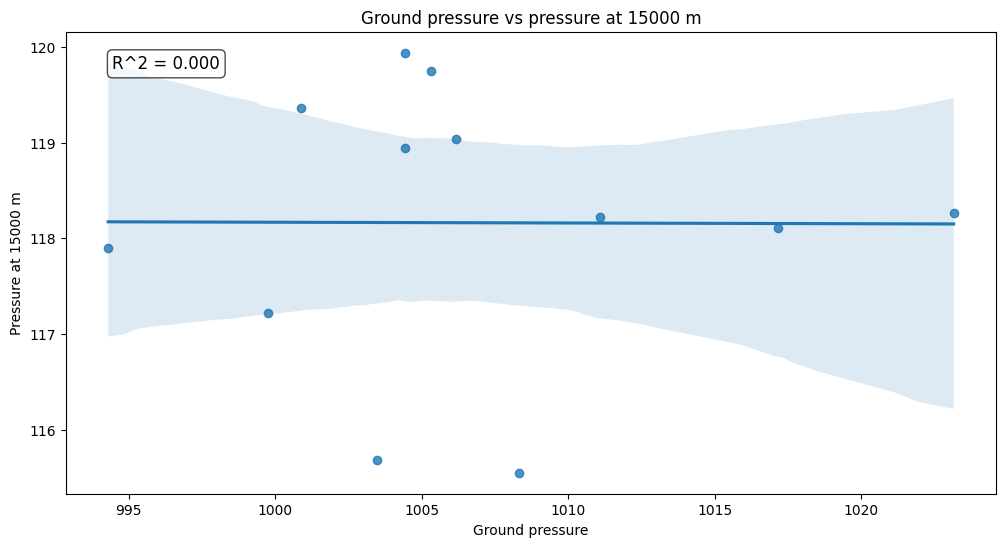

Index(['DateTime', 'Height_m', 'Pressure_hPa', 'Temperature_C'], dtype='object')


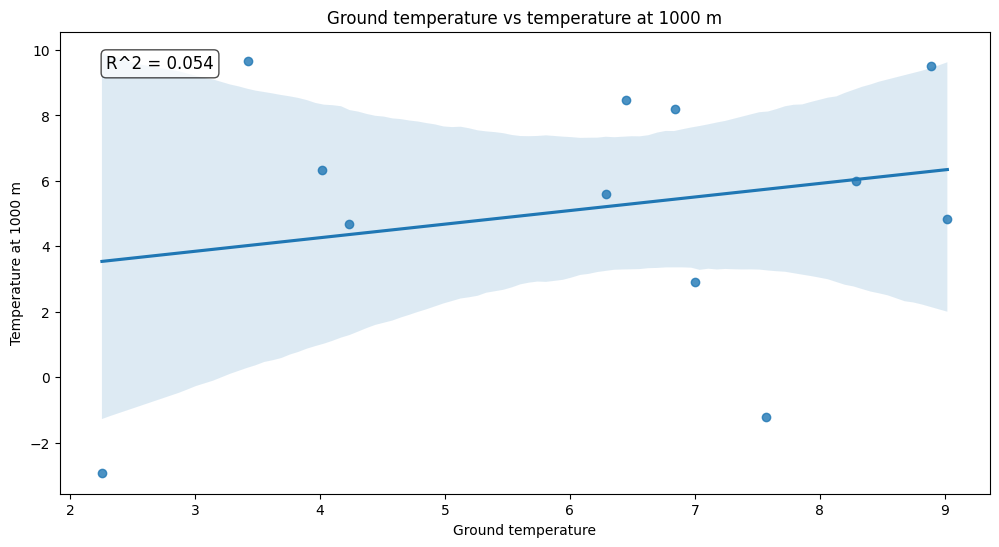

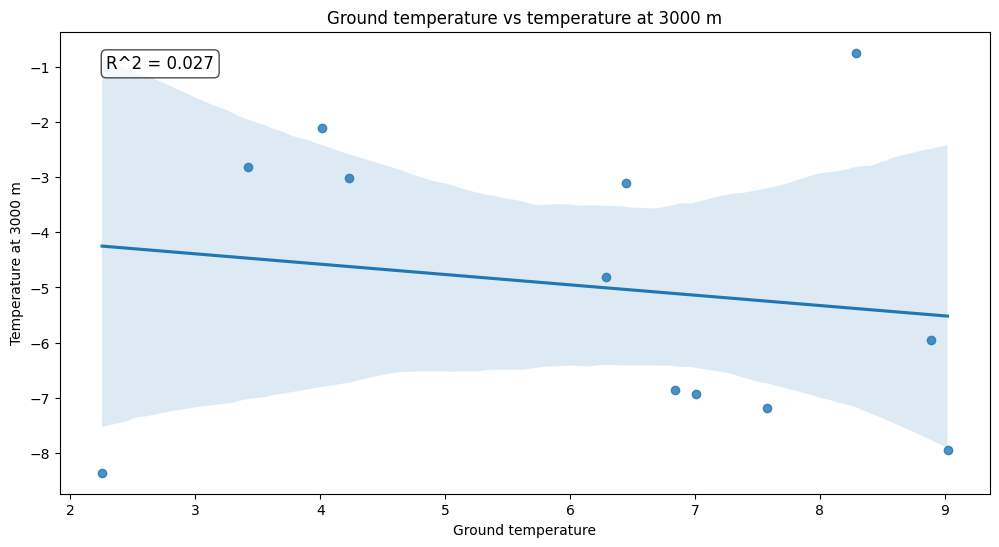

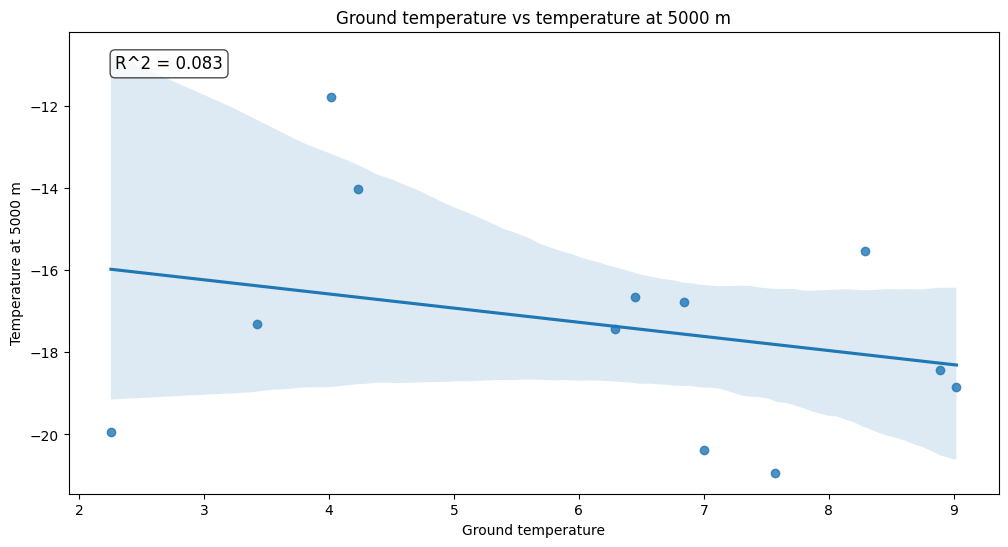

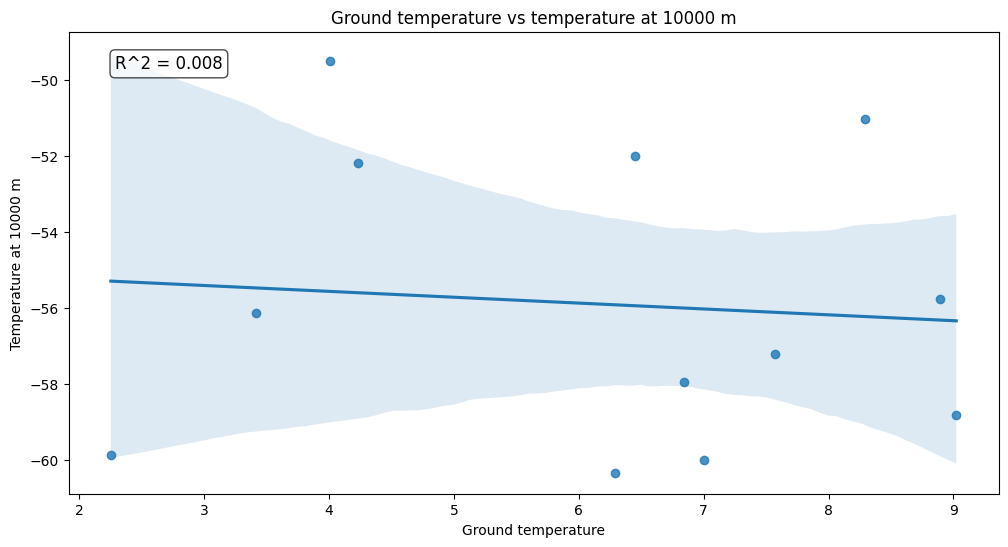

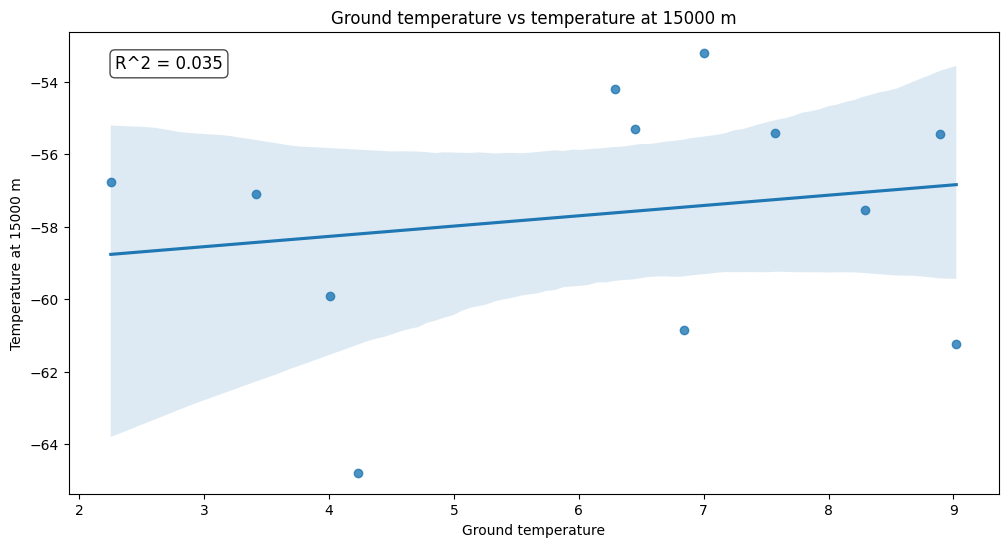

In [ ]:

import seaborn as sns

# Comparison plot between ground pressure and pressure at different height with regression line and R^2
heights_m = [1000, 3000, 5000, 10000, 15000]
print(df.columns)
for height in heights_m:
  # Scatter plot with regression line
  plt.figure (figsize=(12,6))
  sns.regplot (x=pivot_df_pressure[50],y=pivot_df_pressure[height])
  plt.title (f'Ground pressure vs pressure at {height} m')
  plt.xlabel ('Ground pressure')
  plt.ylabel (f'Pressure at {height} m')
  x = pivot_df_pressure[50]                 # Ground level pressure
  y = pivot_df_pressure[height]
  coeffs = np.polyfit(x, y, 1)              # Compute regression line given the ground pressure and the pressure at each height
  fit_fn = np.poly1d (coeffs)               # 1st degree polynomial
  y_pred = fit_fn(x)                        # Predicted y values
  residuals = y - y_pred
  dev_st = np.std (residuals)               # Standard deviation of residuals
  # Compute R^2
  ss_res = np.sum((y - y_pred) ** 2)                # sum of squared residuals
  ss_tot = np.sum((y - np.mean(y)) ** 2)            # total sum of squares
  r_squared = 1 - (ss_res / ss_tot)                 # Coefficient of determination
  eq_text = f'R^2 = {r_squared:.3f}'
  plt.annotate(eq_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha="left", va="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))
  plt.show()


# Comparison plot between ground temperature and temperature at different height with regression line and R^2
heights_m = [1000, 3000, 5000, 10000, 15000]
print(df.columns)
for height in heights_m:
  # Scatter plot with regression line
  plt.figure (figsize=(12,6))
  sns.regplot (x=pivot_df_temperature[50],y=pivot_df_temperature[height])
  plt.title (f'Ground temperature vs temperature at {height} m')
  plt.xlabel ('Ground temperature')
  plt.ylabel (f'Temperature at {height} m')
  x = pivot_df_temperature[50]                 # Ground level temperature
  y = pivot_df_temperature[height]
  coeffs = np.polyfit(x, y, 1)              # Compute regression line given the ground temperature and the temperature at each height
  fit_fn = np.poly1d (coeffs)               # 1st degree polynomial
  y_pred = fit_fn(x)                        # Predicted y values
  residuals = y - y_pred
  dev_st = np.std (residuals)               # Standard deviation of residuals
  # Compute R^2
  ss_res = np.sum((y - y_pred) ** 2)                # sum of squared residuals
  ss_tot = np.sum((y - np.mean(y)) ** 2)            # total sum of squares
  r_squared = 1 - (ss_res / ss_tot)                 # Coefficient of determination
  eq_text = f'R^2 = {r_squared:.3f}'
  plt.annotate(eq_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha="left", va="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))
  plt.show()

# Correlation heatmap
Here we can analyse the correlation between atmospheric parameters at different heights. The heatmap is a square matrix where each cell indicates the parameter r, the coefficient of correlation between the parameter in the row and the the parameter in the column.

r ranges from -1 to 1. If it is negative it indicates an inverse correlation between the parameters, while if it is positive the correlation is direct. The closer the coefficient is to ± 1, the stronger the correlation.

The main diagonal contains only ones because every parameter is perfectly correlated with itself.

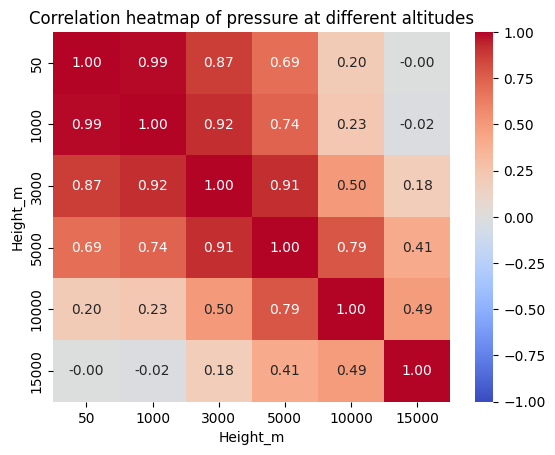

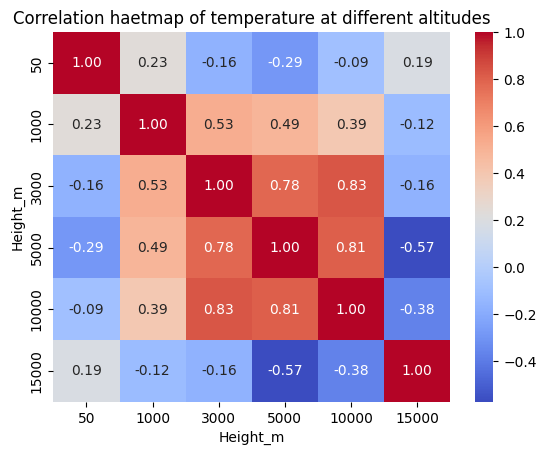

In [ ]:
# Pressure correlation heatmap
plt.figure()
plt.title('Correlation heatmap of pressure at different altitudes')
corr_matrix_pres = pivot_df_pressure.corr()
sns.heatmap (corr_matrix_pres,annot=True, # show correlation values in each cell
           fmt=".2f", # 2 decimals format
             cmap="coolwarm", # color map type
             vmin=-1, vmax=1 #full correlation range
             )
plt.show()

# Temperature correlation heatmap
plt.figure()
plt.title('Correlation haetmap of temperature at different altitudes')
corr_matrix_temp = pivot_df_temperature.corr()
sns.heatmap (corr_matrix_temp, annot=True, fmt=".2f", cmap= "coolwarm")
plt.show()

# Vertical mean temperature profile
This code calculates the mean temperature at each altitude over the selected period.

It then generates a vertical profile plot, where the x-axis shows the average temperature and the y-axis shows the corresponding height.

This plot allows you to examine how temperature varies with altitude on average, highlighting the vertical structure of the atmosphere at the station over the chosen period.


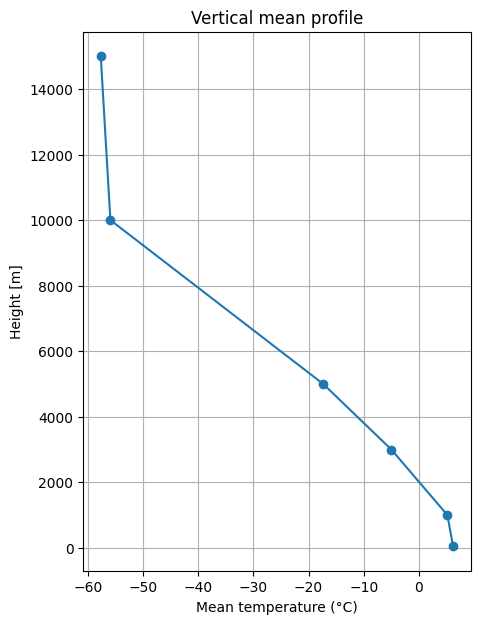

In [ ]:
import matplotlib.pyplot as plt

# Compute mean temperature for each height
mean_profile = pivot_df_temperature.mean()

# Plot the vertical mean profile
plt.figure(figsize=(5,7))
plt.plot(mean_profile.values, mean_profile.index, marker='o')
plt.xlabel("Mean temperature (°C)")
plt.ylabel("Height [m]")
plt.title("Vertical mean profile")
plt.grid(True)
plt.show()